In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr#;xr.set_options(display_style='text') 
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *
from tools.generalTools import qsat,compute_N
from orographicPrecipitation.observationsAndERA5.linearWaveModels import second_derivative_matrix,linear_w_generalized, w_to_Tprime,w_to_qprime,z_to_p_standard
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile,k_vector

from calc_GW_LRF import make_interp_matrix

SCRATCH='/global/cscratch1/sd/qnicolas/'

import scipy.linalg as spl
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

%load_ext autoreload
%autoreload 2

# Functions

In [2]:
kuangdata = loadmat("/global/u2/q/qnicolas/orographicPrecipitation/steadyLRF.mat")

Mkuang=kuangdata['M']
pres=kuangdata['pres'][:,0]
tmean=kuangdata['tmean'][:,0]
qmean=kuangdata['qmean'][:,0]
zrce = kuangdata['z'][:,0]
zT = zrce[:-2]
zQ = zrce[:14]

#Reverse positive eigenvalue
lambdas,P = spl.eig(Mkuang)
lambdas[5]*=-1
Pm1 = spl.inv(P)
Mkuang2 = np.real(np.dot(np.dot(P,np.diag(lambdas)),Pm1))

In [3]:
g = 9.81
Lv = 2.5e6
cp=1004.
Rd = 287.
T0=300.

In [4]:
samgrid = np.loadtxt("/global/homes/q/qnicolas/SAM6.11.8/RCE/grd")[:,0]
zz_full = np.concatenate(([0.],samgrid,[27300,27500])) # increase top resolution for BC
N0=0.01;U0=10;k0=2*np.pi/100e3;hhat0=1.
q0 = 0.02*np.exp(-zz_full/2e3)
dq0dz = np.gradient(q0,zz_full)

In [5]:
stat = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_STAT/RCE_128x128x64_ref_rce.nc")

Nsam = np.sqrt(g/T0*stat.DSE[-240:].mean('time').differentiate('z'))
Nsam[0] = Nsam[1]
Nsam[-2:] = Nsam[-3]
Nsam_full = np.concatenate(([Nsam[0]],Nsam,[Nsam[-1],Nsam[-1]]))

dqdzsam = stat.QV[-240:].mean('time').differentiate('z')/1e3
dqdzsam_full = np.concatenate(([dqdzsam[0]],dqdzsam,[dqdzsam[-1],dqdzsam[-1]]))

/global/common/software/m3310/xrdask.2023.04.qn/lib/python3.9/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


# GW on nonuniform grid

In [6]:
from finitediff import get_weights

def make_D_fornberg(y,order,npoints=7):
    """
    Computes a differentiation matrix for the mth derivative on a nonuniform 
    grid, using a npoints-point stencil (uses Fornberg's algorithm)
    
    Parameters
    ----------
    y       : numpy.ndarray
        Grid.
    order   : int
        Order of differentiation.
    npoints : int
        Number of points for the finite difference stencil
        
    Returns
    -------
    D : numpy.ndarray, 2D
        Differentiation matrix.
    """
    N=len(y)
    assert N>=npoints
    D=np.zeros((N,N))
    for i in range(npoints//2):
        D[ i,:npoints] = get_weights(y[:npoints],y[i],-1,order)[:,order]
        D[-i-1,-npoints:] = get_weights(y[-npoints:],y[-i-1],-1,order)[:,order] 
    for i in range(npoints//2,N-npoints//2):
        D[i,i-npoints//2:i+npoints//2+1] = get_weights(y[i-npoints//2:i+npoints//2+1],y[i],-1,order)[:,order]   
    return D

def make_A(z,lz2,k):
    n = len(z)
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = make_D_fornberg(z,2,npoints=5) #Matrix of second differentiation
    A = D2 + np.diag(lz2-k**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)

    # second order one-sided finite difference for the top derivative
    dz1 = z[-1]-z[-2]
    dz2 = z[-2]-z[-3]
    beta = -(dz1+dz2)/(dz1*dz2)
    gamma = dz1/(dz2*(dz1+dz2))
    alpha = -beta-gamma
    print(alpha*2*dz1,beta*2*dz1,gamma*2*dz1)
    print(beta*dz1**2+gamma*(dz1+dz2)**2)
    A[-1,-3:] = np.array([gamma,beta,alpha])
    A[-1,-1] -=  1j* mtop    
    
    return A

def gw_mode_forced(z,lz2,k,hhatk,U0,qhatk):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = q_hat, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    """
    n = len(z)
    
    A = make_A(z,lz2,k)
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    b[1:-1]= qhatk[1:-1]
    
    return np.linalg.solve(A,b)

def coupled_gw_mode(z,zrce,ds0dz,dq0dz,k,hhatk,U0,MM,coupling='full',itp_matrices=None):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = q_hat, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    q_hat is coupled here.
    """
    n = len(z)
    dz = z[1]-z[0]
    
    A = make_A(z,ds0dz*g/T0/U0**2,k)
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    
    strat_matrix = np.vstack((np.diag(ds0dz),np.diag(dq0dz)*1000))
    
    if itp_matrices is None:
        itp1_matrix = np.block([[make_interp_matrix(z,zrce[:26]),np.zeros((26,len(z)))],[np.zeros((14,len(z))),make_interp_matrix(z,zrce[:14])]])
        itp2_matrix = make_interp_matrix(zrce[:26],z)
        itp3_matrix = np.block([[itp2_matrix,np.zeros((len(z),14))],[np.zeros((len(z),26)),make_interp_matrix(zrce[:14],z)]])
    else: 
        itp1_matrix,itp2_matrix,itp3_matrix = itp_matrices
    
    if coupling=='full':
        MMitp = np.linalg.multi_dot((itp3_matrix,MM,itp1_matrix))
        rhs_matrix = g/T0/U0**2 * np.linalg.multi_dot((MMitp[:len(z)]/86400,np.linalg.inv(MMitp/86400-1j*k*U0*np.eye(2*len(z))),strat_matrix))
        A[1:-1] -= rhs_matrix[1:-1]
        ww = np.linalg.solve(A,b)
        Tq = np.linalg.multi_dot((np.linalg.inv(MMitp/86400-1j*k*U0*np.eye(2*len(z))),strat_matrix,ww))
        QcQq = np.dot(MMitp,Tq)
        return ww,Tq[:len(z)],Tq[len(z):]/1e3,QcQq[:len(z)],QcQq[len(z):]
    elif coupling=='noq':
        MMitp = np.linalg.multi_dot((itp3_matrix,MM,itp1_matrix))
        rhs_matrix = g/T0/U0**2 * np.linalg.multi_dot((MMitp[:len(z)]/86400,np.linalg.inv(np.vstack((MMitp[:len(z)],np.zeros((len(z),2*len(z)))))/86400-1j*k*U0*np.eye(2*len(z))),strat_matrix))
        A[1:-1] -= rhs_matrix[1:-1]
        ww = np.linalg.solve(A,b)
        Tq = np.linalg.multi_dot((np.linalg.inv(np.vstack((MMitp[:len(z)],np.zeros((len(z),2*len(z)))))/86400-1j*k*U0*np.eye(2*len(z))),strat_matrix,ww))
        QcQq = np.dot(MMitp,Tq)
        return ww,Tq[:len(z)],Tq[len(z):]/1e3,QcQq[:len(z)],QcQq[len(z):]        
    else:
        ww = np.linalg.solve(A,b)        
        Tq = -1/(1j*k*U0)*np.dot(strat_matrix,ww)
        QcQq = np.linalg.multi_dot((itp3_matrix,MM,itp1_matrix,Tq))
        b[1:-1] += g/T0/U0**2*QcQq[:len(z)][1:-1]/86400
        ww = np.linalg.solve(A,b)
        Tq = np.linalg.multi_dot((itp3_matrix,np.linalg.inv(MM/86400-1j*k*U0*np.eye(40)),itp1_matrix,strat_matrix,ww))
        return ww,Tq[:len(z)],Tq[len(z):]/1e3,QcQq[:len(z)],QcQq[len(z):]

def QcQqfromTq(MM,zM,zforc,forcT,forcq):
    forcT_interp = np.interp(zM,zforc,forcT)[:26]
    forcq_interp = np.interp(zM,zforc,forcq)[:14]
    forcing=np.concatenate((forcT_interp,forcq_interp))
    reps = np.dot(MM,forcing)
    repQc = np.concatenate((reps[:26],[0.,0.]))
    repQq = np.concatenate((reps[26:],np.zeros(14)))
    return np.interp(zforc,zM,repQc,left=0.,right=0.),np.interp(zforc,zM,repQq,left=0.,right=0.)

# Simulating the GW-convection coupling with the LRF

In [306]:
def gaussianfilter_matrix(n):
    F = np.zeros((n,n))
    F[0,0] = 1; F[-1,-1] = 1
    F[1,:3] = [0.25,0.5,0.25]; F[-2,-3:] = [0.25,0.5,0.25]
    F[2,:5] = np.array([1.,4.,6.,4.,1.])/16.; F[-3,-5:] = np.array([1.,4.,6.,4.,1.])/16.
    for i in range(2,n-2):
        F[i,i-2:i+3] = np.array([1.,4.,6.,4.,1.])/16.
    #for i in range(3,n-3):
    #    F[i,i-3:i+4] = np.array([1.,6.,15.,20.,15.,6.,1.])/64.
    return F


def rhsmatrix(z,zrce,k,U0,MM):
    dz = z[1]-z[0]
    n=len(z)
    
    itp1_matrix = np.block([[make_interp_matrix(z,zrce[:26]),np.zeros((26,len(z)))],[np.zeros((14,len(z))),make_interp_matrix(z,zrce[:14])]])
    itp2_matrix = make_interp_matrix(zrce[:26],z)
    itp3_matrix = np.block([[itp2_matrix,np.zeros((len(z),14))],[np.zeros((len(z),26)),make_interp_matrix(zrce[:14],z)]])

    zeroout_matrix = np.eye(n)
    zeroout_matrix[45:,45:] = 0.
    zeroout_matrix_2 = np.block([[zeroout_matrix,np.zeros((n,n))],[np.zeros((n,n)),zeroout_matrix]])
    gaussianfilter = np.block([[gaussianfilter_matrix(n),np.zeros((n,n))],[np.zeros((n,n)),gaussianfilter_matrix(n)]])
    
    MMinvitp = np.linalg.multi_dot((zeroout_matrix_2,gaussianfilter,itp3_matrix, spl.inv(MM/86400), itp1_matrix))

    rhsmatrix = np.block([[np.zeros((n,n)),np.zeros((n,2*n))],
                          [np.zeros((2*n,n)),-1j*k*U0*MMinvitp]
                         ])
    
    rhsmatrix[0] = 0.
    rhsmatrix[len(z)-1] = 0.
    return rhsmatrix

def lhsmatrix_rhsvec(z,ds0dz,dq0dz,k,hhatk,U0):
    n=len(z)
    A = make_A(z,ds0dz*g/T0/U0**2,k)
    b = 1j*np.zeros(3*n)
    b[0] = 1j*k*U0*hhatk    
    
    I1 = np.eye(n)
    I1[0,0]=0.;I1[-1,-1]=0.
    
    zeroout_matrix = np.eye(n)
    zeroout_matrix[45:,45:] = 0.
    
    return np.block([[A,-g/T0/U0**2*I1,np.zeros((n,n))],[np.dot(zeroout_matrix,np.diag(ds0dz)),-np.eye(n),np.zeros((n,n))],[np.dot(zeroout_matrix,np.diag(dq0dz)*1000),np.zeros((n,n)),-np.eye(n)]]),b

AA,bb = lhsmatrix_rhsvec(zz_full,Nsam_full**2*T0/g,dqdzsam_full,k0,hhat0,U0)
BB = rhsmatrix(zz_full,zrce,k0,U0,Mkuang2)

ww = gw_mode_forced(zz_full,Nsam_full**2/U0**2,k0,hhat0,U0,0*zz_full)
bprime = (-ww*Nsam_full**2)/(1j*k0*U0)
Tprime = bprime/g*300.
qprime = -ww*dqdzsam_full/(1j*k0*U0)*1e3
Qcprime,Qqprime= QcQqfromTq(Mkuang2,zrce,zz_full,Tprime,qprime)#np.zeros(2*len(Tprime))
wT0 = np.concatenate((ww,Qcprime/86400,Qqprime/86400))
wT = wT0

BB2 = 0.8*BB
wTs = []

for i in range(10):
    wT = spl.solve(AA-BB, np.dot(BB2-BB,wT) + bb)
    wTs.append(wT)

plt.plot(np.imag(wT0[:len(zz_full)]),zz_full)
plt.plot(np.imag(wT[:len(zz_full)]),zz_full)
plt.figure()
plt.plot(np.imag(wT0[len(zz_full):2*len(zz_full)]),zz_full)
plt.plot(np.imag(wT[len(zz_full):2*len(zz_full)]),zz_full)
plt.figure()
plt.plot([np.sum((wTT - wT)**2) for wTT in wTs])

2.7733642524361435 -3.260951760083746 0.4875875076476026
5.684341886080802e-14
2.7733642524361435 -3.260951760083746 0.4875875076476026
5.684341886080802e-14


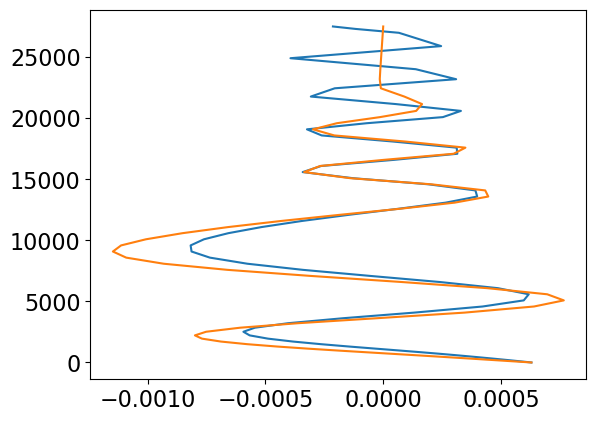

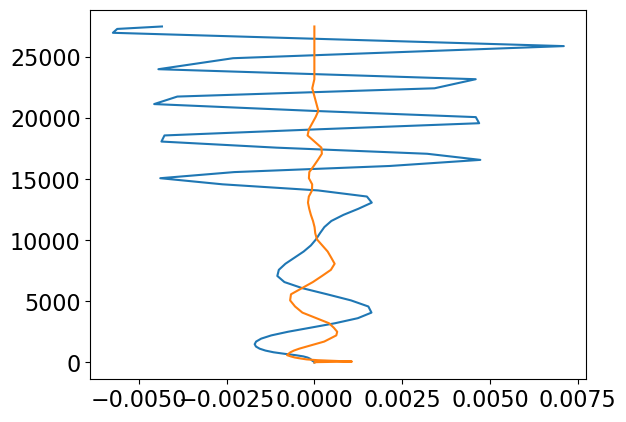

In [26]:
AA,bb = lhsmatrix_rhsvec(zz_full,Nsam_full**2*T0/g,k0,hhat0,U0)
BB = first_rhsmatrix(zz_full,zrce,Nsam_full**2*T0/g,dqdzsam_full,k0,U0,Mkuang2)
BB2 = second_rhsmatrix(zz_full,zrce,Nsam_full**2*T0/g,dqdzsam_full,k0,U0,Mkuang)

ww = gw_mode_forced(zz_full,Nsam_full**2/U0**2,k0,hhat0,U0,0*zz_full)
bprime = (-ww*Nsam_full**2)/(1j*k0*U0)
Tprime = bprime/g*300.
qprime = -ww*dqdzsam_full/(1j*k0*U0)
Qprime=np.zeros(2*len(Tprime))
wT0 = np.concatenate((ww,Tprime,qprime,Qprime))
wT = wT0

MM = AA-BB2
NN = -BB2

for i in range(10):
#    wT = spl.solve(AA,np.dot(BB,wT)+bb)
    wT = spl.solve(MM,np.dot(BB2+NN,wT)+bb)
    
plt.plot(np.imag(wT0[:len(zz_full)]),zz_full)
plt.plot(np.imag(wT[:len(zz_full)]),zz_full)
plt.figure()
plt.plot(np.imag(wT0[len(zz_full):2*len(zz_full)]),zz_full)
plt.plot(np.imag(wT[len(zz_full):2*len(zz_full)]),zz_full)

# Writing SAM lsf file

2.7733642524361435 -3.260951760083746 0.4875875076476026
5.684341886080802e-14
2.7733642524361435 -3.260951760083746 0.4875875076476026
5.684341886080802e-14


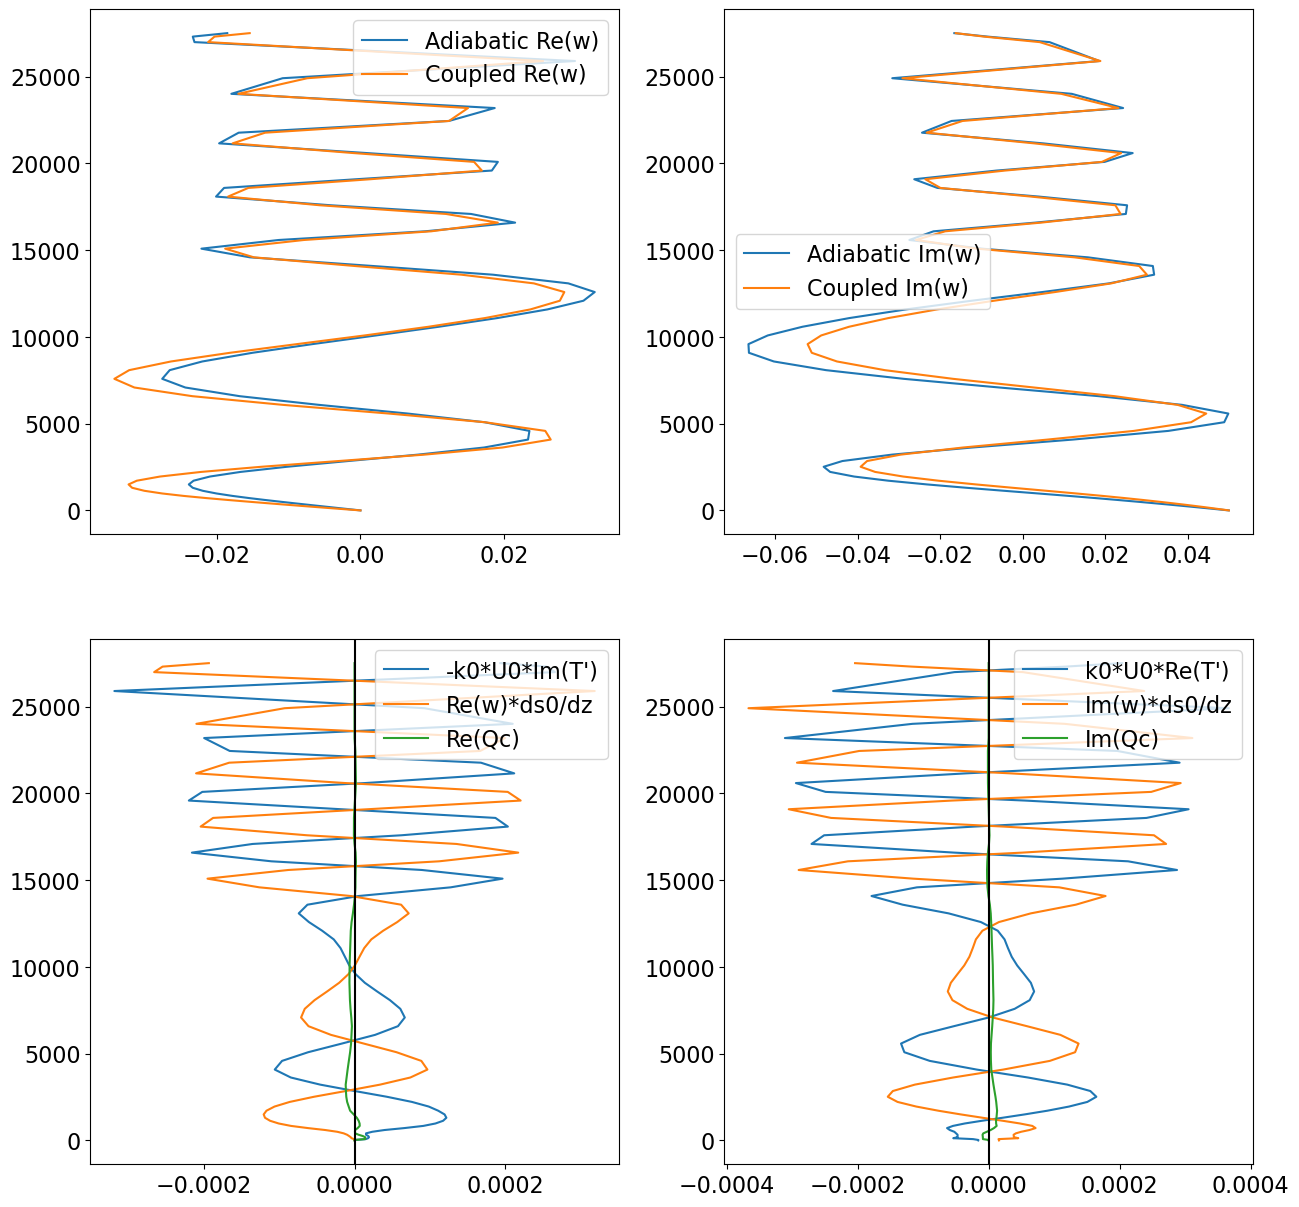

In [324]:
## large-scale w
kSAM = 1e-4
hhatSAM = 50.

w0 = gw_mode_forced(zz_full,Nsam_full**2/U0**2,kSAM,hhatSAM,U0,0*zz_full)
w1,T1,_,Qc1,Qq1 = coupled_gw_mode(zz_full,zrce,Nsam_full**2*T0/g,dqdzsam_full,kSAM,hhatSAM,U0,Mkuang2,coupling='full',itp_matrices=None)

_,axs = plt.subplots(2,2,figsize=(15,15))
axs[0,0].plot(np.real(w0),zz_full,label="Adiabatic Re(w)")
axs[0,0].plot(np.real(w1),zz_full,label="Coupled Re(w)")
axs[0,0].legend()

axs[1,0].plot(-kSAM*U0*np.imag(T1),zz_full,label = "-k0*U0*Im(T')")
axs[1,0].plot(np.real(w1)*(Nsam_full**2*T0/g),zz_full,label="Re(w)*ds0/dz")
axs[1,0].plot(np.real(Qc1)/86400,zz_full,label="Re(Qc)")
axs[1,0].axvline(0.,color='k')
axs[1,0].legend()

axs[0,1].plot(np.imag(w0),zz_full,label="Adiabatic Im(w)")
axs[0,1].plot(np.imag(w1),zz_full,label="Coupled Im(w)")
axs[0,1].legend()

axs[1,1].plot(kSAM*U0*np.real(T1),zz_full,label = "k0*U0*Re(T')")
axs[1,1].plot(np.imag(w1)*(Nsam_full**2*T0/g),zz_full,label="Im(w)*ds0/dz")
axs[1,1].plot(np.imag(Qc1)/86400,zz_full,label="Im(Qc)")
axs[1,1].axvline(0.,color='k')
axs[1,1].legend()

In [329]:
Qc = Qc1/86400
Qq = Qq1/86400
Qc[45:] = 0.
Qq[45:] = 0.
tls = -(np.real(Qc))[1:-2]
qls = -(np.real(Qq))[1:-2]/1000

wls = 0.*tls

#tls = -(-kSAM*U0*np.imag(T1)[1:-2]) # applied on the rhs of the temperature eqn
#qls = -(-kSAM*U0*np.imag(q1/1000.) # applied on the rhs of the temperature eqn
#wls = np.real(w1)[1:-2]

In [330]:
SAMdir = "/global/homes/q/qnicolas/SAM6.11.8/MOUNTAINWAVE/"
f = open(SAMdir+"lsf", "w")
print(' z[m] p[mb] tls[K/s] qls[kg/kg/s] uls vls wls[m/s]',file=f)
for day in (0.,1000.):
    print(' {:>4.1f},  64,{:>10.2f}   day,levels,pres0'.format(day,stat.Ps[-1]),file=f)
    for i,z in enumerate(stat.z):
        print('{:>10.3f} {:>10.3f} {: 10e} {: 10e} {:>10.3f} {:>10.3f} {:>10.3f}'.format(z,stat.p[i],tls[i],qls[i],0.,0.,wls[i]),file=f)
f.close()

In [331]:
tls = -(np.imag(Qc))[1:-2]
qls = -(np.imag(Qq))[1:-2]/1000
wls = 0.*tls


In [332]:
SAMdir = "/global/homes/q/qnicolas/SAM6.11.8.im/MOUNTAINWAVE/"
f = open(SAMdir+"lsf", "w")
print(' z[m] p[mb] tls[K/s] qls[kg/kg/s] uls vls wls[m/s]',file=f)
for day in (0.,1000.):
    print(' {:>4.1f},  64,{:>10.2f}   day,levels,pres0'.format(day,stat.Ps[-1]),file=f)
    for i,z in enumerate(stat.z):
        print('{:>10.3f} {:>10.3f} {: 10e} {: 10e} {:>10.3f} {:>10.3f} {:>10.3f}'.format(z,stat.p[i],tls[i],qls[i],0.,0.,wls[i]),file=f)
f.close()

In [ ]:
test = xr.open_dataset("/pscratch/sd/q/qnicolas/GWdata/GW_12345.nc")

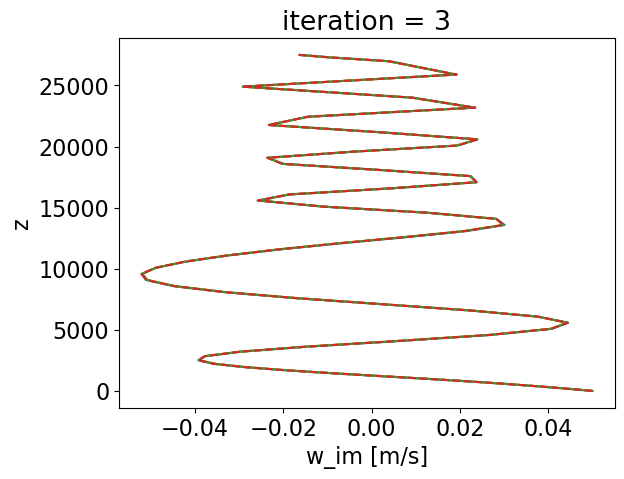

In [ ]:
test.w_im[0].plot(y='z')
test.w_im[1].plot(y='z')
test.w_im[2].plot(y='z')
test.w_im[3].plot(y='z',linestyle='--')

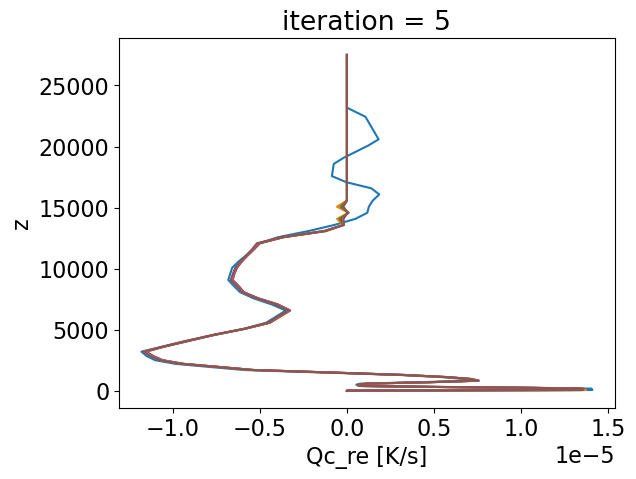

In [104]:
test.Qc_re[0].plot(y='z')
test.Qc_re[1].plot(y='z')
test.Qc_re[2].plot(y='z')
test.Qc_re[3].plot(y='z')
test.Qc_re[4].plot(y='z')
test.Qc_re[5].plot(y='z')


# Writing SAM rad file

In [8]:
radqr = stat.RADQR[-240:].mean('time')/86400
#radqr[-2:]=0.
#
#radqr_nostrat = radqr
#radqr_nostrat[44:]=0.

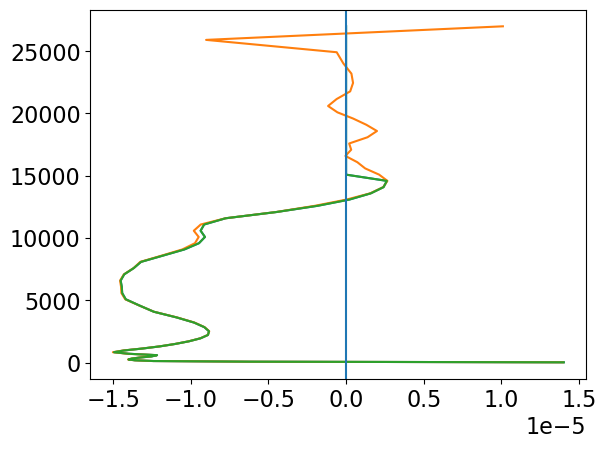

In [363]:
plt.plot(radqr,stat.z)
plt.plot(stat.RADQR[-480:-240].mean('time')/86400,stat.z)
plt.plot(radqr_nostrat,stat.z)
plt.axvline(0.)

In [11]:
SAMdir = "/global/homes/q/qnicolas/SAM6.11.8/RCE/"
f = open(SAMdir+"rad", "w")
print('  z[m] (dt/dt)rad [K/s]',file=f)
for day in (0.,1000.):
    print(' {:>4.1f},  64   day,levels'.format(day),file=f)
    for i,z in enumerate(stat.z):
        print('{:>10.3f}  {: 10e}'.format(z,radqr[i]),file=f)
f.close()

In [12]:
SAMdir = "/global/homes/q/qnicolas/SAM6.11.8/MOUNTAINWAVE/"
f = open(SAMdir+"rad", "w")
print('  z[m] (dt/dt)rad [K/s]',file=f)
for day in (0.,1000.):
    print(' {:>4.1f},  64   day,levels'.format(day),file=f)
    for i,z in enumerate(stat.z):
        print('{:>10.3f}  {: 10e}'.format(z,radqr[i]),file=f)
f.close()

In [13]:
SAMdir = "/global/homes/q/qnicolas/SAM6.11.8.im/MOUNTAINWAVE/"
f = open(SAMdir+"rad", "w")
print('  z[m] (dt/dt)rad [K/s]',file=f)
for day in (0.,1000.):
    print(' {:>4.1f},  64   day,levels'.format(day),file=f)
    for i,z in enumerate(stat.z):
        print('{:>10.3f}  {: 10e}'.format(z,radqr[i]),file=f)
f.close()

# SAM spinup

In [176]:
stat = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_STAT/RCE_128x128x64_ref_rce.nc")

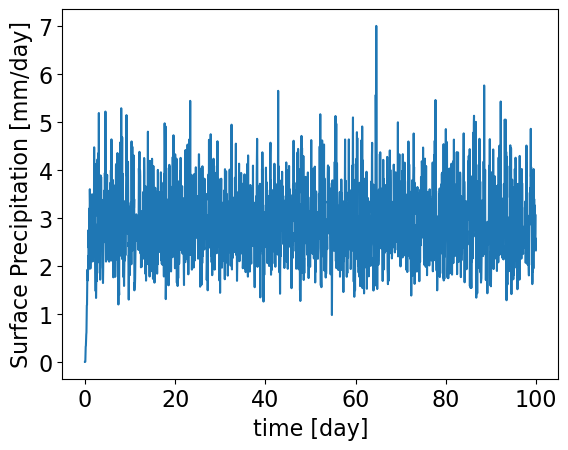

In [177]:
stat.PREC.plot()

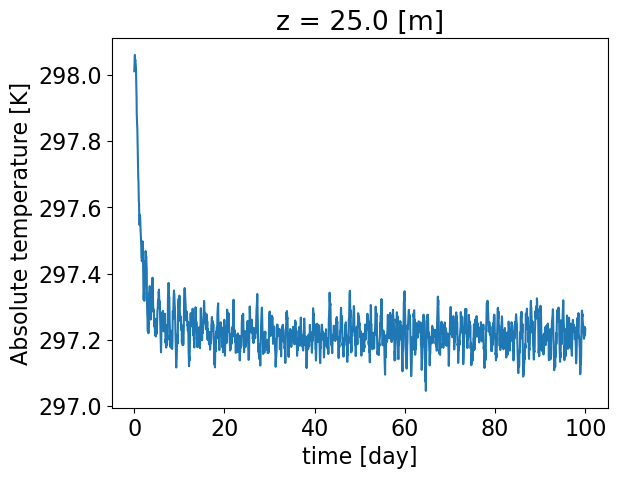

In [178]:
stat.TABS[:,0].plot()

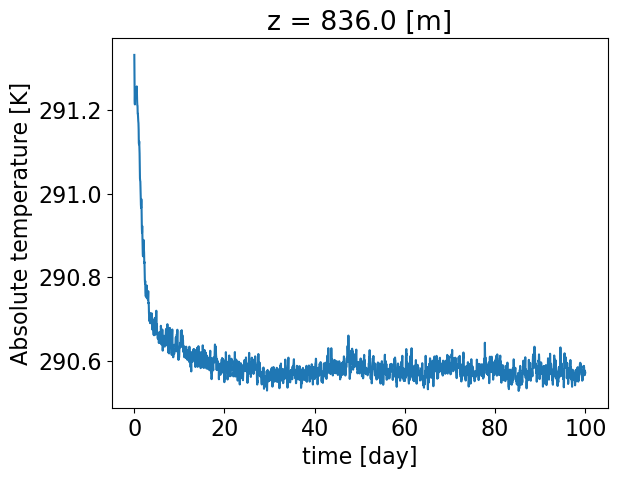

In [179]:
stat.TABS[:,10].plot()

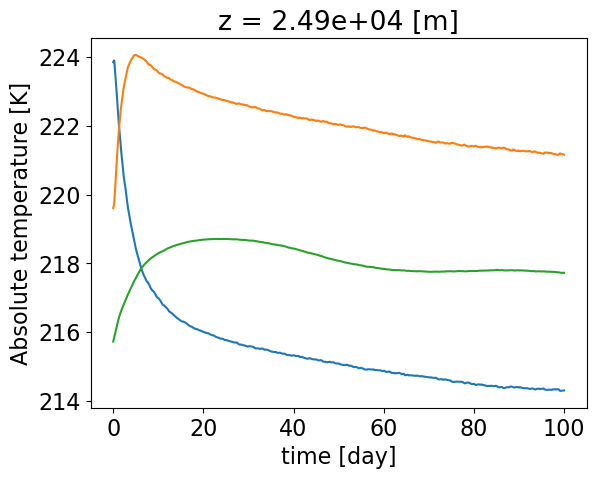

In [180]:
stat.TABS[:,-1].plot()
stat.TABS[:,-2].plot()
stat.TABS[:,-3].plot()

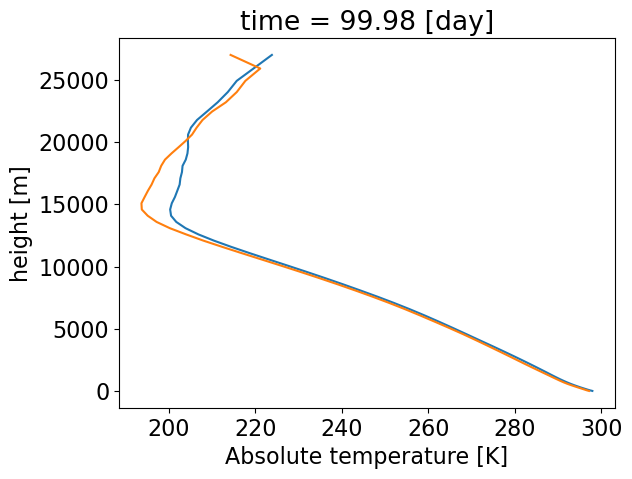

In [182]:
stat.TABS[0].plot(y='z')
stat.TABS[-1].plot(y='z')

In [153]:
out2d1 = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_2D/RCE_128x128x64_ref_rce_128.2Dcom_1.nc")

In [157]:
out2d2 = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_2D/RCE_128x128x64_ref_rce_128.2Dcom_2.nc")

In [159]:
out2d3 = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_2D/RCE_128x128x64_ref_rce_128.2Dcom_3.nc")

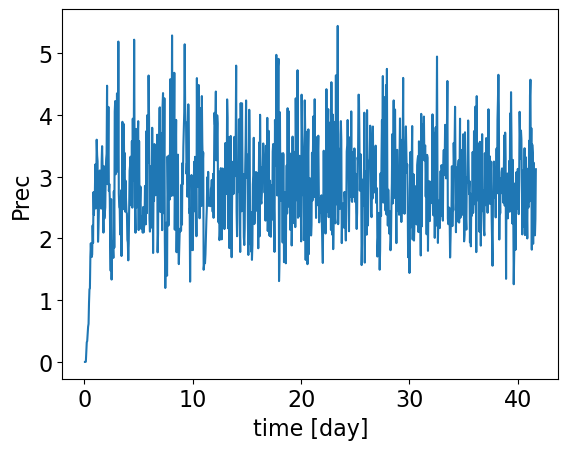

In [156]:
out2d1.Prec.mean(['x','y']).plot()

# Fixed radiation

In [14]:
stat_fixrad = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_STAT/RCE_128x128x64_fixrad_rce.nc")

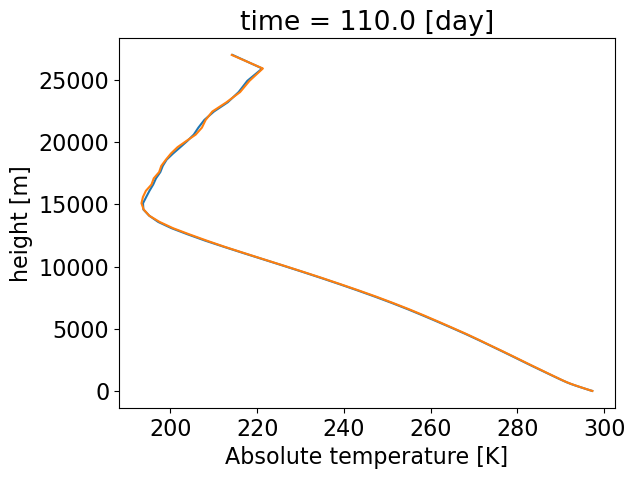

In [15]:
stat_fixrad.TABS[0].plot(y='z')
stat_fixrad.TABS[-1].plot(y='z')

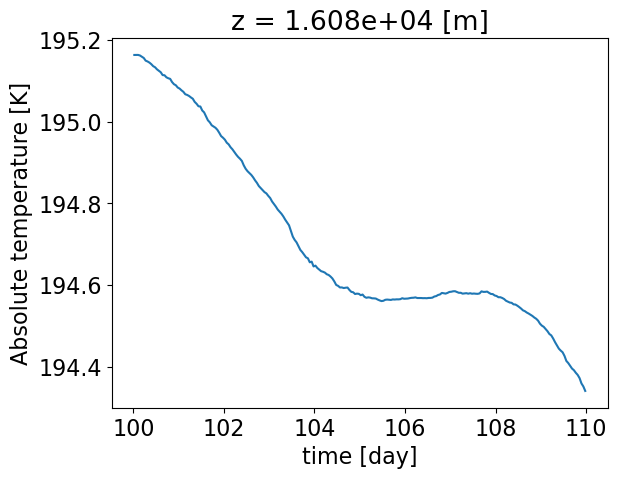

In [22]:
stat_fixrad.TABS.sel(z=16000,method='nearest').plot()

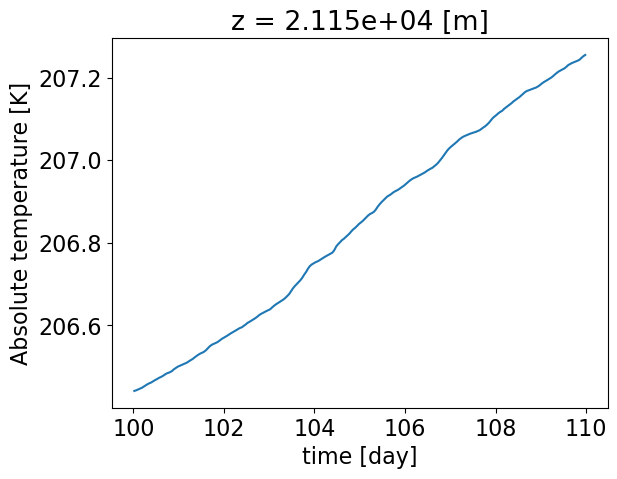

In [18]:
stat_fixrad.TABS.sel(z=21000,method='nearest').plot()

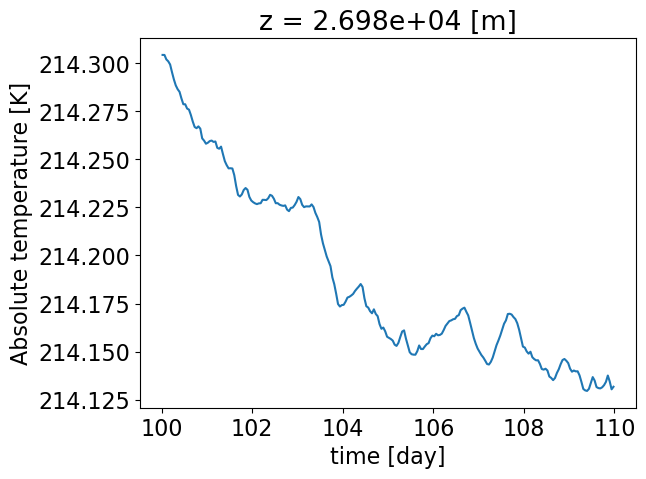

In [19]:
stat_fixrad.TABS.sel(z=35000,method='nearest').plot()

# MTNWAVE re

In [13]:
stat_mtn_re = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMdata/OUT_STAT/MOUNTAINWAVE_128x128x64_mtnwave_k1e-4_h50_U10_real.nc")

In [16]:
stat_mtn_re.time

<xarray.DataArray 'time' (time: 223)>
array([150.02084, 150.0625 , 150.10417, ..., 159.1875 , 159.22917, 159.27084],
      dtype=float32)
Coordinates:
  * time     (time) float32 150.0 150.1 150.1 150.1 ... 159.1 159.2 159.2 159.3
Attributes:
    units:      day
    long_name:  time

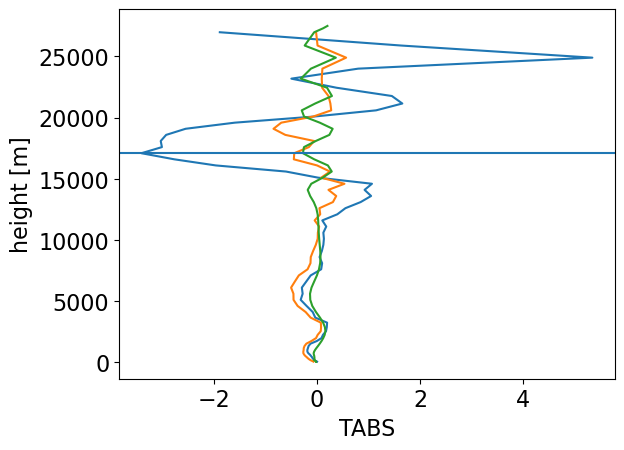

In [341]:
(stat_mtn_re.TABS[-240:].mean('time')-stat.TABS[-240:].mean('time')).plot(y='z')
(stat_mtn_re.TABS[-240:].mean('time')-stat_fixrad.TABS[-240:].mean('time')).plot(y='z')
plt.plot(np.real(T1),zz_full)
#plt.xlim(-10,10)
plt.axhline(stat.z[48])

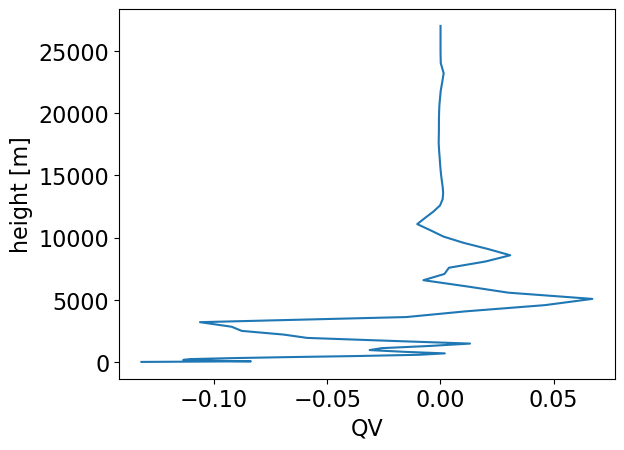

In [342]:
(stat_mtn_re.QV[-240:].mean('time')-stat.QV[-240:].mean('time')).plot(y='z')
#stat.TABS[-240:].mean('time').plot(y='z')
#plt.xlim(-10,10)

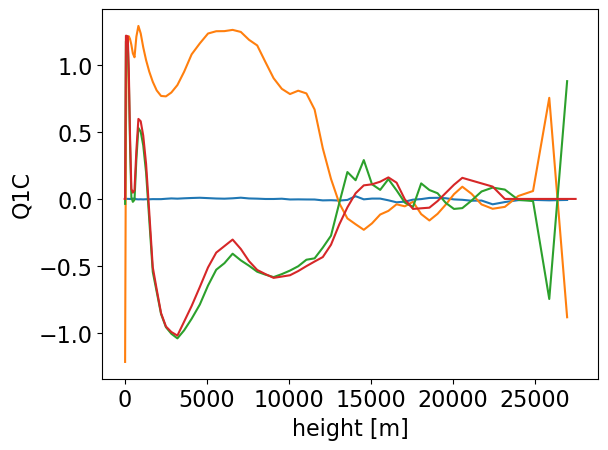

In [345]:
(stat.Q1C+stat.RADQR)[-240:].mean('time').plot()
stat.Q1C[-240:].mean('time').plot()

(stat_mtn_re.Q1C[-240:].mean('time')-stat.Q1C[-240:].mean('time')).plot()

plt.plot(zz_full,np.real(Qc1))

In [346]:
print("Vert. integrated convective heating, RCE, mm/day:", -np.trapz(stat.Q1C[-240:].mean('time'),stat.p)*100/g/2.5e3)
print("Vert. integrated convective heating, MTNWAVE Re, mm/day:", -np.trapz(stat_mtn_re.Q1C.mean('time'),stat_mtn.p)*100/g/2.5e3)
print("Precip, MTNWAVE Re, mm/day:", float(stat_mtn_re.PREC.mean()))
print("LHF, MTNWAVE Re, mm/day:", float((stat_mtn_re.LHF*86400/2.5e6).mean('time')))
print("SHF, MTNWAVE Re, mm/day:", float((stat_mtn_re.SHF*86400/2.5e6).mean('time')))

Vert. integrated convective heating, RCE, mm/day: 3.2765951516309886
Vert. integrated convective heating, MTNWAVE Re, mm/day: 1.7983562691131498
Precip, MTNWAVE Re, mm/day: 1.4962173700332642
LHF, MTNWAVE Re, mm/day: 2.79240125337358
SHF, MTNWAVE Re, mm/day: 0.3237189773171165


# MTNWAVE im

In [353]:
stat_mtn_im = xr.open_dataset("/pscratch/sd/q/qnicolas/SAMimdata/OUT_STAT/MOUNTAINWAVE_128x128x64_mtnwave_k1e-4_h50_U10_imag.nc")

In [355]:
stat_mtn_im

<xarray.Dataset>
Dimensions:   (z: 64, time: 106)
Coordinates:
  * z         (z) float32 25.0 75.0 127.8 186.7 ... 2.49e+04 2.589e+04 2.698e+04
  * time      (time) float32 150.0 150.1 150.1 150.1 ... 154.3 154.3 154.4 154.4
Data variables: (12/257)
    p         (z) float32 ...
    SST       (time) float32 ...
    Ps        (time) float32 ...
    AREAPREC  (time) float32 ...
    WMAX      (time) float32 ...
    UMAX      (time) float32 ...
    ...        ...
    QG        (time, z) float32 ...
    QCCLD     (time, z) float32 ...
    QICLD     (time, z) float32 ...
    QRCLD     (time, z) float32 ...
    QSCLD     (time, z) float32 ...
    QGCLD     (time, z) float32 ...
Attributes:
    SAM version:  
    caseid:       128x128x64_mtnwave_k1e-4_h50_U10_imag

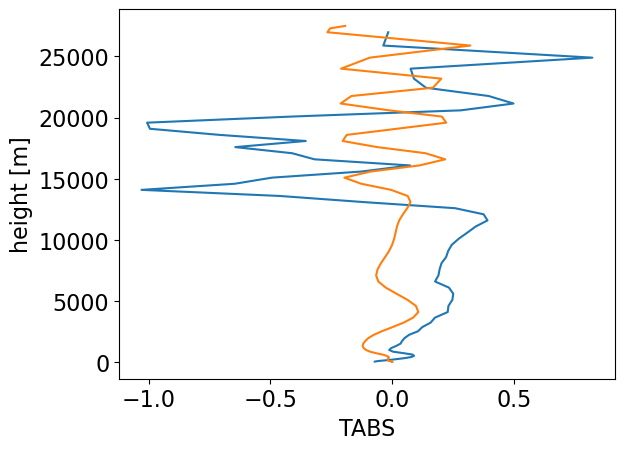

In [359]:
(stat_mtn_im.TABS[-240:].mean('time')-stat_fixrad.TABS[-240:].mean('time')).plot(y='z')
#stat.TABS[-240:].mean('time').plot(y='z')
#plt.xlim(-10,10)
plt.plot(np.imag(T1),zz_full)

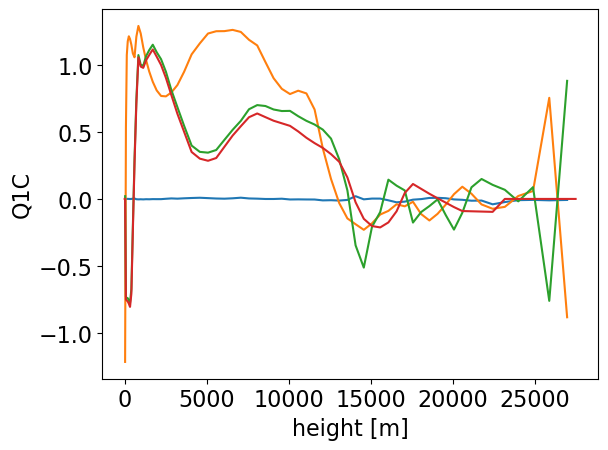

In [351]:
(stat.Q1C+stat.RADQR)[-240:].mean('time').plot()
stat.Q1C[-240:].mean('time').plot()

(stat_mtn_im.Q1C[-240:].mean('time')-stat.Q1C[-240:].mean('time')).plot()

plt.plot(zz_full,np.imag(Qc1))

In [352]:
print("Vert. integrated convective heating, RCE, mm/day:", -np.trapz(stat.Q1C[-240:].mean('time'),stat.p)*100/g/2.5e3)
print("Vert. integrated convective heating, MTNWAVE Im, mm/day:", -np.trapz(stat_mtn_im.Q1C.mean('time'),stat_mtn.p)*100/g/2.5e3)
print("Precip, MTNWAVE Im, mm/day:", float(stat_mtn_im.PREC.mean()))
print("LHF, MTNWAVE Im, mm/day:", float((stat_mtn_im.LHF*86400/2.5e6).mean('time')))
print("SHF, MTNWAVE Im, mm/day:", float((stat_mtn_im.SHF*86400/2.5e6).mean('time')))

Vert. integrated convective heating, RCE, mm/day: 3.2765951516309886
Vert. integrated convective heating, MTNWAVE Im, mm/day: 5.227085622929408
Precip, MTNWAVE Im, mm/day: 4.732010364532471
LHF, MTNWAVE Im, mm/day: 3.101132473374853
SHF, MTNWAVE Im, mm/day: 0.38325530757112325


# Coupled run

In [ ]:
grep -rl "'\./" . | xargs sed -i "s/'\.\//'\/global\/homes\/q\/qnicolas\/SAM6.11.8\//"
grep -rl "'\./" . | xargs sed -i "s/'\.\//'\/global\/homes\/q\/qnicolas\/SAM6.11.8.im\//"


In [ ]:
sed -i "s/nstop    = 500,\!17280,/nstop    = 1800,/" prm

In [ ]:
simname = RCE_128x128x64_fixrad_rce

In [8]:
test = xr.open_dataset("/pscratch/sd/q/qnicolas/GWdata/GW_10082393.nc")

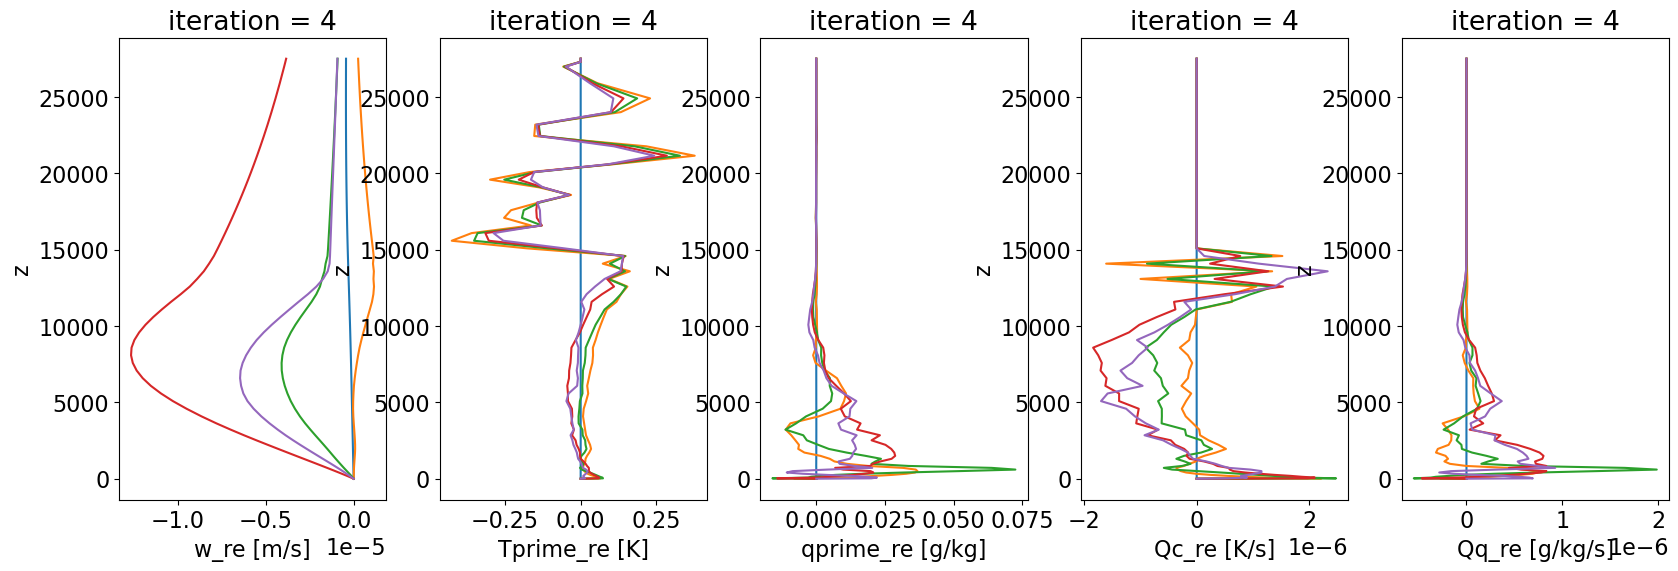

In [9]:
_,axs=plt.subplots(1,5,figsize=(20,6))

for i in range(5):
    test.w_re[i].plot(ax=axs[0],y='z')
    test.Tprime_re[i].plot(ax=axs[1],y='z')
    test.qprime_re[i].plot(ax=axs[2],y='z')
    test.Qc_re[i].plot(ax=axs[3],y='z')
    test.Qq_re[i].plot(ax=axs[4],y='z')


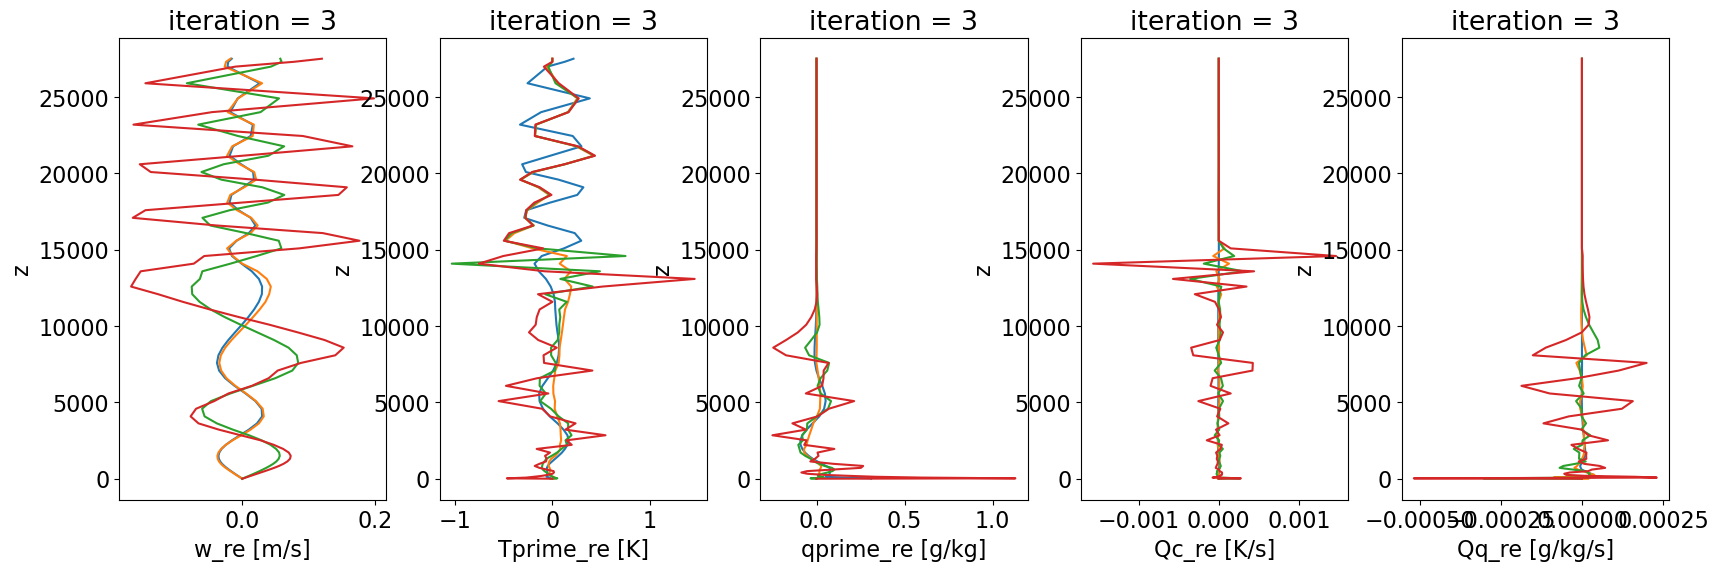

In [9]:
_,axs=plt.subplots(1,5,figsize=(20,6))

test.w_re[0].plot(ax=axs[0],y='z')
test.w_re[1].plot(ax=axs[0],y='z')
test.w_re[2].plot(ax=axs[0],y='z')
test.w_re[3].plot(ax=axs[0],y='z')

test.Tprime_re[0].plot(ax=axs[1],y='z')
test.Tprime_re[1].plot(ax=axs[1],y='z')
test.Tprime_re[2].plot(ax=axs[1],y='z')
test.Tprime_re[3].plot(ax=axs[1],y='z')

test.qprime_re[0].plot(ax=axs[2],y='z')
test.qprime_re[1].plot(ax=axs[2],y='z')
test.qprime_re[2].plot(ax=axs[2],y='z')
test.qprime_re[3].plot(ax=axs[2],y='z')

test.Qc_re[0].plot(ax=axs[3],y='z')
test.Qc_re[1].plot(ax=axs[3],y='z')
test.Qc_re[2].plot(ax=axs[3],y='z')
test.Qc_re[3].plot(ax=axs[3],y='z')

test.Qq_re[0].plot(ax=axs[4],y='z')
test.Qq_re[1].plot(ax=axs[4],y='z')
test.Qq_re[2].plot(ax=axs[4],y='z')
test.Qq_re[3].plot(ax=axs[4],y='z')


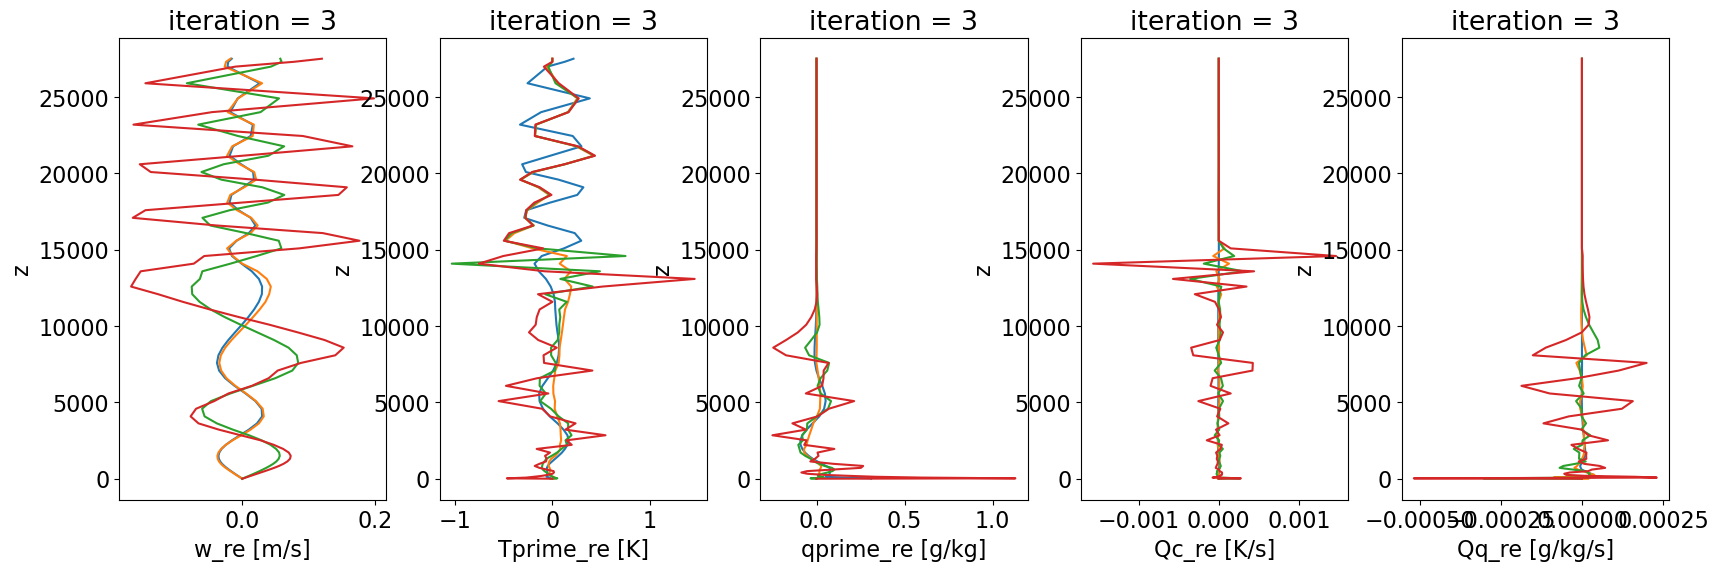

In [49]:
_,axs=plt.subplots(1,5,figsize=(20,6))

test.w_re[0].plot(ax=axs[0],y='z')
test.w_re[1].plot(ax=axs[0],y='z')
test.w_re[2].plot(ax=axs[0],y='z')
test.w_re[3].plot(ax=axs[0],y='z')

test.Tprime_re[0].plot(ax=axs[1],y='z')
test.Tprime_re[1].plot(ax=axs[1],y='z')
test.Tprime_re[2].plot(ax=axs[1],y='z')
test.Tprime_re[3].plot(ax=axs[1],y='z')

test.qprime_re[0].plot(ax=axs[2],y='z')
test.qprime_re[1].plot(ax=axs[2],y='z')
test.qprime_re[2].plot(ax=axs[2],y='z')
test.qprime_re[3].plot(ax=axs[2],y='z')

test.Qc_re[0].plot(ax=axs[3],y='z')
test.Qc_re[1].plot(ax=axs[3],y='z')
test.Qc_re[2].plot(ax=axs[3],y='z')
test.Qc_re[3].plot(ax=axs[3],y='z')

test.Qq_re[0].plot(ax=axs[4],y='z')
test.Qq_re[1].plot(ax=axs[4],y='z')
test.Qq_re[2].plot(ax=axs[4],y='z')
test.Qq_re[3].plot(ax=axs[4],y='z')


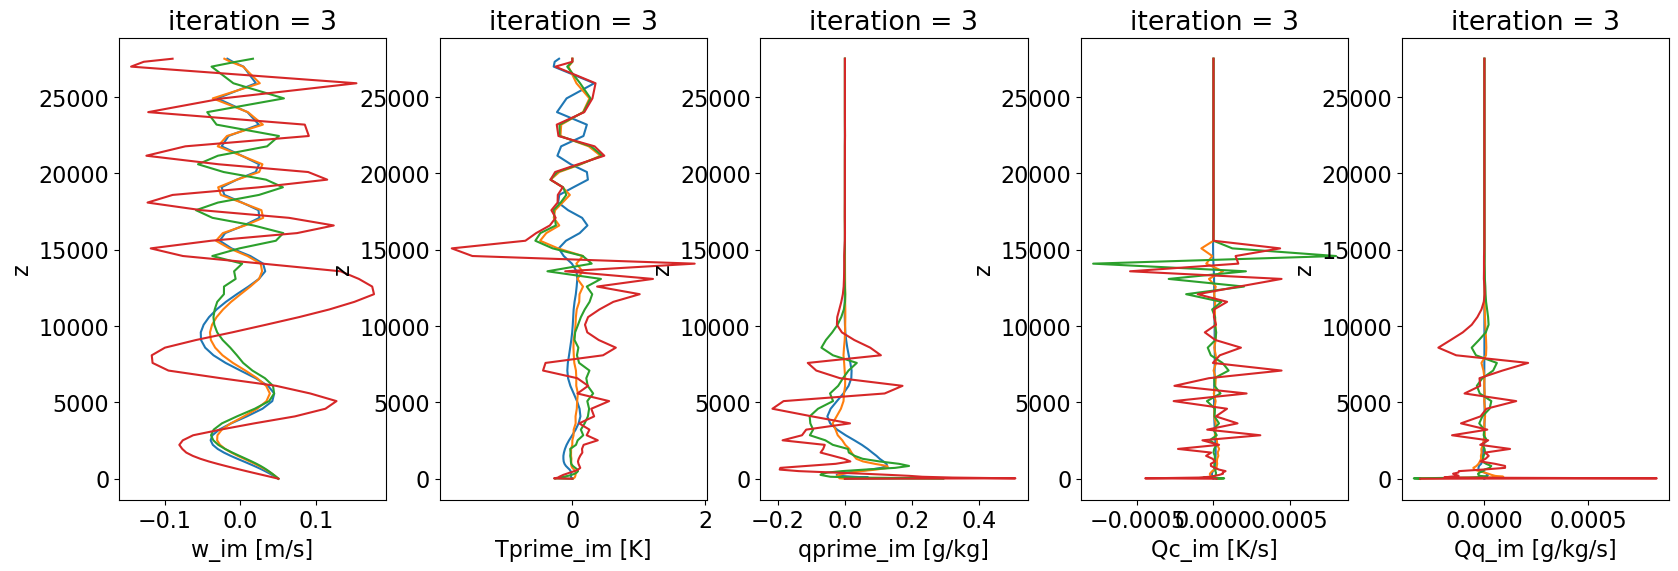

In [50]:
_,axs=plt.subplots(1,5,figsize=(20,6))

test.w_im[0].plot(ax=axs[0],y='z')
test.w_im[1].plot(ax=axs[0],y='z')
test.w_im[2].plot(ax=axs[0],y='z')
test.w_im[3].plot(ax=axs[0],y='z')

test.Tprime_im[0].plot(ax=axs[1],y='z')
test.Tprime_im[1].plot(ax=axs[1],y='z')
test.Tprime_im[2].plot(ax=axs[1],y='z')
test.Tprime_im[3].plot(ax=axs[1],y='z')

test.qprime_im[0].plot(ax=axs[2],y='z')
test.qprime_im[1].plot(ax=axs[2],y='z')
test.qprime_im[2].plot(ax=axs[2],y='z')
test.qprime_im[3].plot(ax=axs[2],y='z')

test.Qc_im[0].plot(ax=axs[3],y='z')
test.Qc_im[1].plot(ax=axs[3],y='z')
test.Qc_im[2].plot(ax=axs[3],y='z')
test.Qc_im[3].plot(ax=axs[3],y='z')

test.Qq_im[0].plot(ax=axs[4],y='z')
test.Qq_im[1].plot(ax=axs[4],y='z')
test.Qq_im[2].plot(ax=axs[4],y='z')
test.Qq_im[3].plot(ax=axs[4],y='z')


In [15]:
test = xr.open_dataset("/pscratch/sd/q/qnicolas/GWdata/GW_12345.nc")

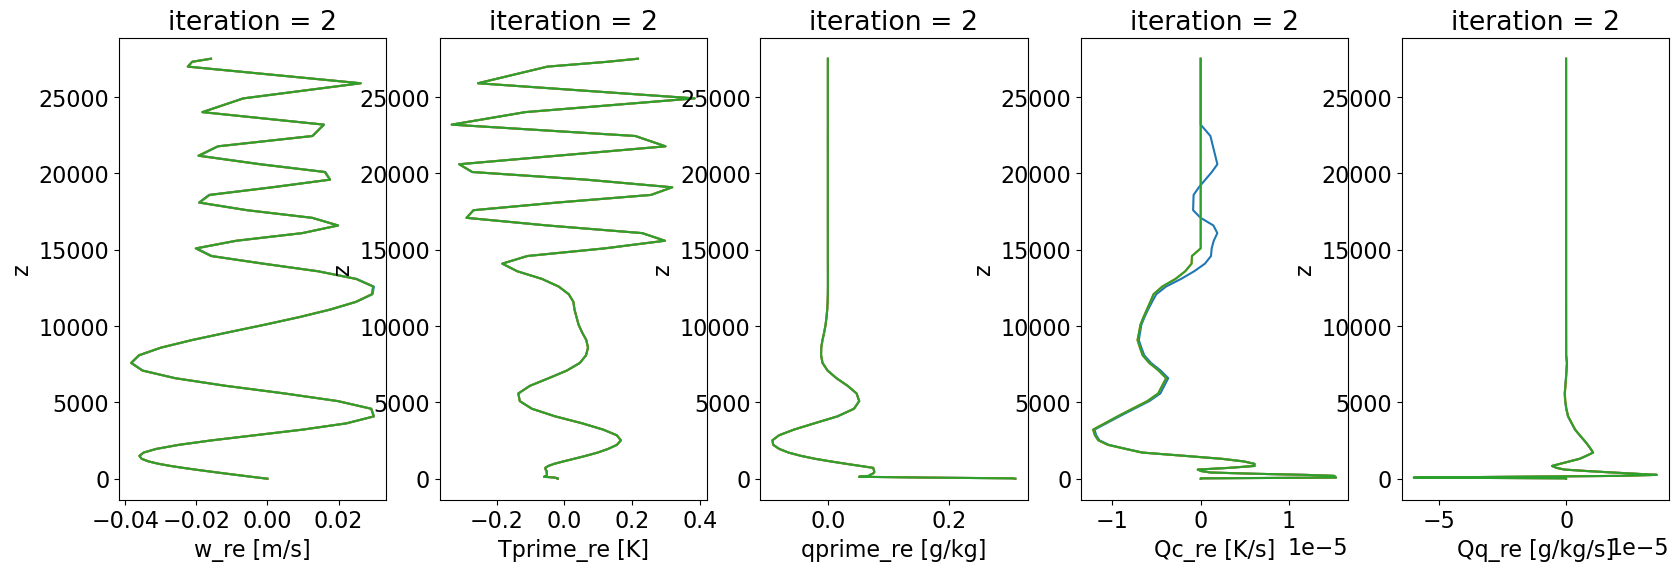

In [41]:
_,axs=plt.subplots(1,5,figsize=(20,6))

test.w_re[0].plot(ax=axs[0],y='z')
test.w_re[1].plot(ax=axs[0],y='z')
test.w_re[2].plot(ax=axs[0],y='z')

test.Tprime_re[0].plot(ax=axs[1],y='z')
test.Tprime_re[1].plot(ax=axs[1],y='z')
test.Tprime_re[2].plot(ax=axs[1],y='z')

test.qprime_re[0].plot(ax=axs[2],y='z')
test.qprime_re[1].plot(ax=axs[2],y='z')
test.qprime_re[2].plot(ax=axs[2],y='z')

test.Qc_re[0].plot(ax=axs[3],y='z')
test.Qc_re[1].plot(ax=axs[3],y='z')
test.Qc_re[2].plot(ax=axs[3],y='z')

test.Qq_re[0].plot(ax=axs[4],y='z')
test.Qq_re[1].plot(ax=axs[4],y='z')
test.Qq_re[2].plot(ax=axs[4],y='z')


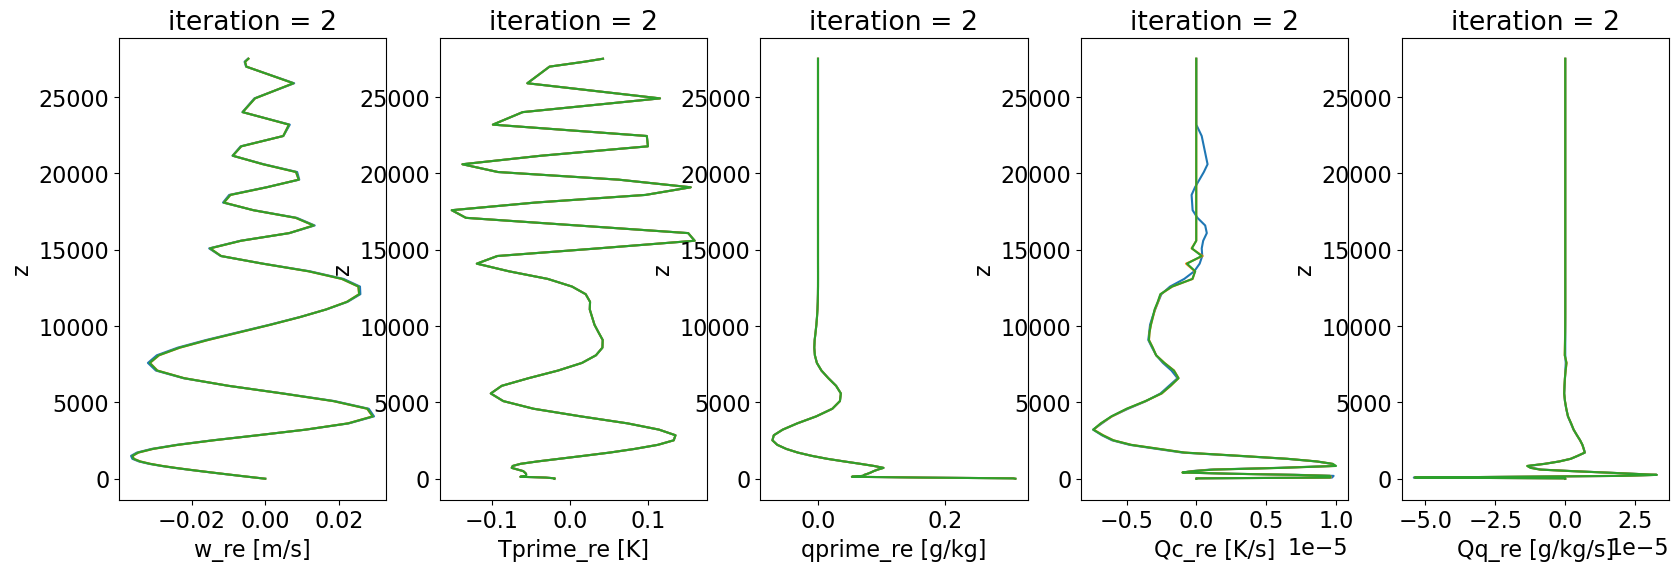

In [16]:
_,axs=plt.subplots(1,5,figsize=(20,6))

test.w_re[0].plot(ax=axs[0],y='z')
test.w_re[1].plot(ax=axs[0],y='z')
test.w_re[2].plot(ax=axs[0],y='z')

test.Tprime_re[0].plot(ax=axs[1],y='z')
test.Tprime_re[1].plot(ax=axs[1],y='z')
test.Tprime_re[2].plot(ax=axs[1],y='z')

test.qprime_re[0].plot(ax=axs[2],y='z')
test.qprime_re[1].plot(ax=axs[2],y='z')
test.qprime_re[2].plot(ax=axs[2],y='z')

test.Qc_re[0].plot(ax=axs[3],y='z')
test.Qc_re[1].plot(ax=axs[3],y='z')
test.Qc_re[2].plot(ax=axs[3],y='z')

test.Qq_re[0].plot(ax=axs[4],y='z')
test.Qq_re[1].plot(ax=axs[4],y='z')
test.Qq_re[2].plot(ax=axs[4],y='z')


In [37]:
python /global/homes/q/qnicolas/perlmutterNotebooks/GW_SAM.py 12345 init
python /global/homes/q/qnicolas/perlmutterNotebooks/GW_SAM.py 12345 update 1
python /global/homes/q/qnicolas/perlmutterNotebooks/GW_SAM.py 12345 update 2
python /global/homes/q/qnicolas/perlmutterNotebooks/GW_SAM.py 12345 update 3


<xarray.Dataset>
Dimensions:    (iteration: 3, z: 67)
Coordinates:
  * iteration  (iteration) int64 0 1 2
  * z          (z) float64 0.0 25.0 75.0 127.8 ... 2.698e+04 2.73e+04 2.75e+04
Data variables:
    w_re       (iteration, z) float64 ...
    w_im       (iteration, z) float64 ...
    Tprime_re  (iteration, z) float64 ...
    Tprime_im  (iteration, z) float64 ...
    qprime_re  (iteration, z) float64 ...
    qprime_im  (iteration, z) float64 ...
    Qc_re      (iteration, z) float64 ...
    Qc_im      (iteration, z) float64 ...
    Qq_re      (iteration, z) float64 ...
    Qq_im      (iteration, z) float64 ...
Attributes:
    description:  GW info, job n°9060564

In [44]:
5*360

1800